# 0. Data overview

- WCEbleedGen
  - bleeding
    - annotations
    - bounding boxes
    - images
  - non-bleeding
    - annotations
    - images

Extracting zip file

In [2]:
DATASET_PATH = '/content/drive/MyDrive/Projects/WCEbleedGen/WCEbleedGen/WCEBleedGen (updated)/'
# drive.mount('/content/drive')

In [3]:
# import zipfile
# import os
# from google.colab import drive

# source_zip_path = '/content/drive/MyDrive/Projects/WCEbleedGen/WCEBleedGen (updated).zip'

# destination_folder = '/content/drive/MyDrive/Projects/WCEbleedGen/WCEbleedGen/'

# os.makedirs(destination_folder, exist_ok=True)

# with zipfile.ZipFile(source_zip_path, 'r') as zip_ref:
#     zip_ref.extractall(destination_folder)

# print(f"Contents extracted to: {destination_folder}")

# Data visualization

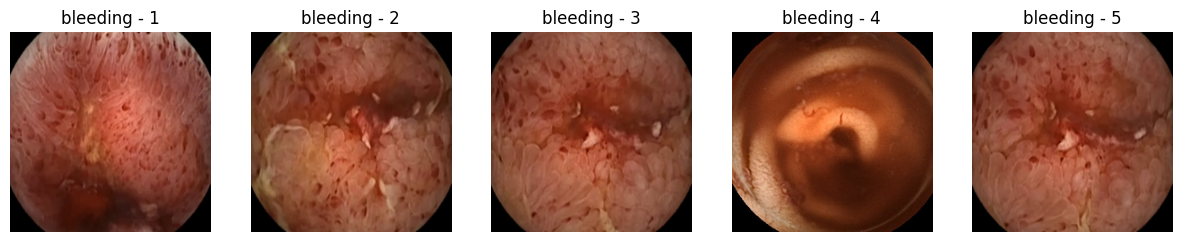

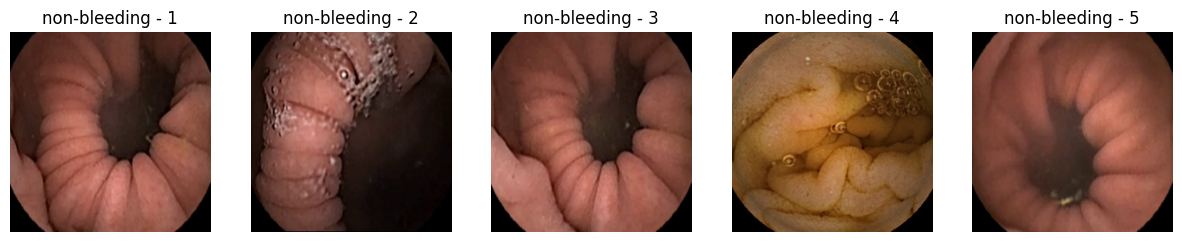

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

# Define the path to your WCEBleedGen dataset
dataset_path = DATASET_PATH

# Function to load and display images
def display_images(category, num_images=5):
    category_path = os.path.join(dataset_path, category, 'images')
    image_files = os.listdir(category_path)[:num_images]

    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(category_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR format
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{category} - {i+1}")
        plt.axis('off')

# Display images from both categories
display_images('bleeding')
display_images('non-bleeding')

plt.show()


# 1. Binary Classification

The following models are trained and evaluated for classifying images into bleeding or non-bleeding

In [5]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from google.colab import drive

# Define the dataset class
class WCEBleedGenDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.categories = os.listdir(root_folder)

        self.images, self.labels = self.load_data()

    def load_data(self):
        images = []
        labels = []
        for category in self.categories:
            category_path = os.path.join(self.root_folder, category, 'images')
            for img_file in os.listdir(category_path):
                img_path = os.path.join(category_path, img_file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR format
                label = self.categories.index(category)
                images.append(img)
                labels.append(label)

        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# Define transformations for data preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load data using the custom dataset class
root_folder = DATASET_PATH
dataset = WCEBleedGenDataset(root_folder, transform=data_transform)

# Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_test_size = len(dataset) - train_size
val_size = val_test_size // 2
test_size = val_test_size - val_size

train_dataset, val_test_dataset = torch.utils.data.random_split(dataset, [train_size, val_test_size])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [val_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract labels for training, validation, and testing
y_train = [label for _, label in train_loader.dataset]
y_val = [label for _, label in val_loader.dataset]
y_test = [label for _, label in test_loader.dataset]

# Function to flatten images for PCA
def flatten_images(images):
    return images.view(images.size(0), -1)


In [6]:
print(y_train[:5])
print(y_val[:5])
print(y_test[:5])

[1, 1, 1, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]


In [7]:
from sklearn.metrics import accuracy_score
import torch

def evaluate(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)


In [8]:
import numpy as np
from sklearn.decomposition import PCA

# Flatten images
train_images_pca = flatten_images(torch.cat([flatten_images(images) for images, _ in train_loader]))
val_images_pca = flatten_images(torch.cat([flatten_images(images) for images, _ in val_loader]))
test_images_pca = flatten_images(torch.cat([flatten_images(images) for images, _ in test_loader]))


In [9]:
from sklearn.linear_model import LogisticRegression

# Perform PCA
n_components = 50

n_components_list = [50, 75, 100, 200]

def perform_pca(n_components, test_set=False):
  pca = PCA(n_components=n_components)
  train_pca = pca.fit_transform(train_images_pca.numpy())
  val_pca = pca.transform(val_images_pca.numpy())

  # Display results
  print(f'Explained variance ratio: {np.sum(pca.explained_variance_ratio_)}')

  # Train Logistic Regression on PCA-transformed data
  logreg = LogisticRegression()
  logreg.fit(train_pca, y_train)  # Assuming y_train is the original labels

  # Evaluate Logistic Regression on test set
  predictions_pca_logreg = logreg.predict(val_pca)

  # Display results
  acc_pca_logreg = accuracy_score(y_val, predictions_pca_logreg)
  print(f'Accuracy (PCA + Logistic Regression): {acc_pca_logreg}')

  if test_set:
    test_pca = pca.transform(test_images_pca.numpy())
    # Evaluate Logistic Regression on test set
    test_predictions_pca_logreg = logreg.predict(test_pca)

    # Display results
    test_acc_pca_logreg = accuracy_score(y_test, test_predictions_pca_logreg)
    print(f'Test Set Accuracy (PCA + Logistic Regression): {test_acc_pca_logreg} for n_components = {n_components}')

  return acc_pca_logreg


def check_n_components(n_components_list):
  results_dic = {}
  for n_components in n_components_list:
    acc_pca_logreg = perform_pca(n_components, test_set=False)
    results_dic[n_components] = acc_pca_logreg

  return results_dic

In [10]:
n_components_list = [10, 30]
pca_log_val_results = check_n_components(n_components_list)

Explained variance ratio: 0.712145209312439
Accuracy (PCA + Logistic Regression): 0.48091603053435117
Explained variance ratio: 0.8358811736106873
Accuracy (PCA + Logistic Regression): 0.49236641221374045


In [11]:
final_dic = {10: 0.3549618320610687, 30: 0.37786259541984735, 50: 0.45038167938931295, 75: 0.4312977099236641, 100: 0.4389312977099237, 200: 0.4732824427480916}
for n_components, accuracy in final_dic.items():
    print(f'{n_components}: {accuracy:.3f}')

10: 0.355
30: 0.378
50: 0.450
75: 0.431
100: 0.439
200: 0.473


In [12]:
perform_pca(50, test_set=True)

Explained variance ratio: 0.8724523782730103
Accuracy (PCA + Logistic Regression): 0.5114503816793893
Test Set Accuracy (PCA + Logistic Regression): 0.4961832061068702 for n_components = 50


0.5114503816793893

Trying out logistic regression with different number of components, the following dictionary summarizes the validation set: accuracy obtained

* 10: 0.355
* 30: 0.378
* 50: 0.450
* 75: 0.431
* 100: 0.439
* 200: 0.473

50 seems to be giving a better validation set accuracy for fewer number of components

But the accuracy is still low

Therefore, PCA combined with SVM is evaluated in a similar way

Final test_set accuracy is

In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Perform LDA
lda = LDA(n_components=1)
train_images_lda = flatten_images(torch.cat([flatten_images(images) for images, _ in train_loader]))
test_images_lda = flatten_images(torch.cat([flatten_images(images) for images, _ in test_loader]))
train_lda = lda.fit_transform(train_images_lda.numpy(), [label for _, label in train_loader.dataset])
test_lda = lda.transform(test_images_lda.numpy())

# Display results
print(f'Explained variance ratio: {lda.explained_variance_ratio_[0]}')


NameError: name 'flatten_images' is not defined

In [14]:
import torch.nn as nn
import torch.optim as optim

# Define the ANN model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224 * 224 * 3, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ann_model = ANNModel().to(device)

# Initialize criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    ann_model.train()
    for images, labels in train_loader:
        # Move images and labels to the same device as the model
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = ann_model(images)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

# Evaluate the model
ann_model.eval()  # Set the model to evaluation mode
predictions_ann, true_labels_ann = evaluate(ann_model, test_loader)
predictions_ann = (predictions_ann > 0.5).astype(int)

# Display results
acc_ann = accuracy_score(true_labels_ann, predictions_ann)
print(f'Accuracy (ANN): {acc_ann}')


Accuracy (ANN): 0.5038167938931297


In [16]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define VGG16 model
class VGG16Model(nn.Module):
    def __init__(self):
        super(VGG16Model, self).__init__()
        vgg_model = models.vgg16(pretrained=True)
        vgg_model.classifier[-1] = nn.Linear(4096, 1)
        self.vgg_model = vgg_model

    def forward(self, x):
        return self.vgg_model(x)

# Initialize VGG16 model, criterion, and optimizer
vgg16_model = VGG16Model().to('cuda')
criterion_vgg16 = nn.BCEWithLogitsLoss()
optimizer_vgg16 = optim.Adam(vgg16_model.parameters(), lr=0.001)

# Training loop
epochs = 5  # Make sure to define the number of epochs
for epoch in range(epochs):
    vgg16_model.train()
    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.float().view(-1, 1).to('cuda')
        optimizer_vgg16.zero_grad()
        outputs = vgg16_model(images)
        loss = criterion_vgg16(outputs, labels)
        loss.backward()
        optimizer_vgg16.step()

# Evaluate the model
vgg16_model.eval()  # Set the model to evaluation mode
predictions_vgg16, true_labels_vgg16 = evaluate(vgg16_model, test_loader)
predictions_vgg16 = (predictions_vgg16 > 0.5).astype(int)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.8MB/s]


In [15]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define ResNet model
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        resnet_model = models.resnet50(pretrained=True)
        resnet_model.fc = nn.Linear(2048, 1)
        self.resnet_model = resnet_model

    def forward(self, x):
        return self.resnet_model(x)

# Initialize ResNet model, criterion, and optimizer
resnet_model = ResNetModel().to('cuda')
criterion_resnet = nn.BCEWithLogitsLoss()
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)

# Training loop
epochs = 5  # Make sure to define the number of epochs
for epoch in range(epochs):
    resnet_model.train()
    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.float().view(-1, 1).to('cuda')
        optimizer_resnet.zero_grad()
        outputs = resnet_model(images)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

# Evaluate the model
resnet_model.eval()  # Set the model to evaluation mode
predictions_resnet, true_labels_resnet = evaluate(resnet_model, test_loader)
predictions_resnet = (predictions_resnet > 0.5).astype(int)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


In [18]:
acc_resnet = accuracy_score(true_labels_resnet, predictions_resnet)
acc_vgg16 = accuracy_score(true_labels_vgg16, predictions_vgg16)

print(acc_vgg16)
print(acc_resnet)

0.5038167938931297
0.9198473282442748


Save models

In [ ]:
# Save ResNet model
torch.save(resnet_model.state_dict(), 'resnet_model.pth')

# Save VGG16 model
torch.save(vgg16_model.state_dict(), 'vgg16_model.pth')

# Save ANN model
torch.save(ann_model.state_dict(), 'ann_model.pth')

# Segmentation

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Define the dataset class
class SegmentationDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.categories = os.listdir(root_folder)

        self.images, self.annotations = self.load_data()

    def load_data(self):
        images = []
        annotations = []
        for category in self.categories:
            category_path = os.path.join(self.root_folder, category, 'images')
            for img_file in os.listdir(category_path):
                start = img_file.find('(')
                end = img_file.find(')', start)
                img_number = img_file[start + 1: end]
                ann_file = 'ann- (' + img_number + ').png'
                img_path = os.path.join(category_path, img_file)
                img = Image.open(img_path).convert('RGB')
                annotation_path = os.path.join(self.root_folder, category, 'annotations', ann_file)
                annotation = Image.open(annotation_path).convert('L')  # Assuming annotations are grayscale images
                images.append(img)
                annotations.append(annotation)

        return images, annotations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        annotation = self.annotations[idx]

        if self.transform:
            img = self.transform(img)
            annotation = self.transform(annotation)

        return img, annotation

# Define transformations for data preprocessing
data_transform = transforms.Compose([
    # transforms.Resize((256, 256)),  # Adjust size as needed
    transforms.ToTensor(),
])

# Load data using the custom dataset class
root_folder = DATASET_PATH
dataset = SegmentationDataset(root_folder, transform=data_transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Define your VAE architecture here

    def forward(self, x):
        # Implement the forward pass

# Initialize VAE model, criterion, and optimizer
vae_model = VAE()
criterion_vae = # Choose an appropriate loss function for segmentation
optimizer_vae = optim.Adam(vae_model.parameters(), lr=0.001)

# Training loop for VAE
epochs = 5  # Define the number of epochs
for epoch in range(epochs):
    vae_model.train()
    for images, annotations in train_loader:
        optimizer_vae.zero_grad()
        outputs = vae_model(images)
        loss = criterion_vae(outputs, annotations)
        loss.backward()
        optimizer_vae.step()

# Evaluate the VAE model (Note: This is a placeholder, actual evaluation depends on the model architecture)
vae_model.eval()
predictions_vae = vae_model(test_loader)
accuracy_vae = calculate_accuracy(predictions_vae, test_loader)
print(f'Accuracy (VAE): {accuracy_vae}')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the CNN model with ResNet architecture
class CNNResNet(nn.Module):
    def __init__(self):
        super(CNNResNet, self).__init__()
        # Use a pre-trained ResNet model as the backbone
        resnet_model = models.resnet18(pretrained=True)

        # Extract the layers before the final classification layer
        self.features = nn.Sequential(*list(resnet_model.children())[:-1])

        # Add a convolutional layer to reduce the number of output channels
        self.additional_conv = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x):
        x = self.features(x)
        x = self.additional_conv(x)
        return x

# Initialize CNN with ResNet model, criterion, and optimizer
cnn_resnet_model = CNNResNet()
criterion_cnn_resnet = # Choose an appropriate loss function for segmentation
optimizer_cnn_resnet = optim.Adam(cnn_resnet_model.parameters(), lr=0.001)

# Training loop for CNN with ResNet
for epoch in range(epochs):
    cnn_resnet_model.train()
    for images, annotations in train_loader:
        optimizer_cnn_resnet.zero_grad()
        outputs = cnn_resnet_model(images)
        loss = criterion_cnn_resnet(outputs, annotations)
        loss.backward()
        optimizer_cnn_resnet.step()

# Evaluate the CNN with ResNet model (Note: This is a placeholder, actual evaluation depends on the model architecture)
cnn_resnet_model.eval()
predictions_cnn_resnet = cnn_resnet_model(test_loader)
accuracy_cnn_resnet = calculate_accuracy(predictions_cnn_resnet, test_loader)
print(f'Accuracy (CNN with ResNet): {accuracy_cnn_resnet}')


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import vision_transformer

# Define the ViT model
class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()
        self.transformer = vision_transformer.vit_base_patch16_224(pretrained=False, num_classes=1)

    def forward(self, x):
        return self.transformer(x)

# Initialize ViT model, criterion, and optimizer
vit_model = ViT()
criterion_vit = nn.BCEWithLogitsLoss()
optimizer_vit = optim.Adam(vit_model.parameters(), lr=0.001)

# Training loop for ViT
for epoch in range(epochs):
    vit_model.train()
    for images, annotations in train_loader:
        optimizer_vit.zero_grad()
        outputs = vit_model(images)
        loss = criterion_vit(outputs, annotations.view(-1, 1))
        loss.backward()
        optimizer_vit.step()

# Evaluate the ViT model
vit_model.eval()
predictions_vit = vit_model(test_loader)
accuracy_vit = calculate_accuracy(predictions_vit, test_loader)
print(f'Accuracy (ViT): {accuracy_vit}')


# Object detection